# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Machine Learning e IA em Ambientes Distribuídos</font>

# Projeto - Parte 1 - Data Cleansing e Feature Engineering

In [1]:
# Imports
import subprocess
import sys
import os
import re
import time
import atexit
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import concat, col, udf, lag, date_add, explode, lit, unix_timestamp
from pyspark.sql.functions import month, weekofyear, dayofmonth
from pyspark.sql.types import *
from pyspark.sql.types import DateType
from pyspark.sql.dataframe import *
from pyspark.sql.window import Window
from pyspark.sql import Row
from pyspark.ml.classification import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml.feature import StandardScaler, PCA, RFormula
from pyspark.ml import Pipeline, PipelineModel

start_time = time.time()

## Importação dos Dados

#### Inicialmente, encontramos alguns problemas ao ler os dados

- Para o Spark 2.0 e superior, podemos usar o sqlContext.read.csv para importar dados diretamente para o contexto do Spark. A importação de dados parece funcionar bem e você também pode realizar alguma transformação de dados sem nenhum problema. No entanto, quando tentamos mostrar as n primeiras linhas de todos os dados (por exemplo, data.show (3)) ou fazer alguma manipulação de dados em determinadas colunas, encontramos erro de "Null Pointer" ou "NumberFormatException: null".

- No nosso caso, foi porque para algumas colunas numéricas com registros ausentes contendo "", o Spark ainda reconhece essas colunas como numéricas, mas de alguma forma não pode analisá-las corretamente. Esperemos que a versão futura do Spark possa lidar com esse problema de maneira mais inteligente.

- Corrigimos o problema reformando os dados antes de carregar no contexto do Spark como formato csv.

`` `bash
  cat data.csv | tr -d "\" \ ""> dataset.csv

#### Import dos Dados

In [2]:
# Import 
dataFile = "dataset.csv"
dataFileSep = ','
df = sqlContext.read.csv(dataFile, header=True, sep=dataFileSep, inferSchema=True, nanValue="", mode='PERMISSIVE')

## Exploração e Limpeza de Dados

Primeiro, vamos examinar a dimensão do conjunto de dados e o esquema de dados.

In [3]:
# Verificando as dimensões dos dados
df.count(), len(df.columns)

(2085102, 172)

In [4]:
# Verificando se o problema de df.show() foi corrigido
df.show(1)

+--------+--------------------+-------------+-------------+-------------+-------------+--------------+-------------+-------------+--------------+--------------+--------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+------------+----------

In [5]:
# Verificando o esquema de dados
df.dtypes

[('DeviceID', 'string'),
 ('Date', 'timestamp'),
 ('Categorical_1', 'int'),
 ('Categorical_2', 'int'),
 ('Categorical_3', 'int'),
 ('Categorical_4', 'int'),
 ('Problem_Type_1', 'int'),
 ('Usage_Count_1', 'int'),
 ('Usage_Count_2', 'int'),
 ('Problem_Type_2', 'int'),
 ('Problem_Type_3', 'int'),
 ('Problem_Type_4', 'int'),
 ('Warning_1.2', 'int'),
 ('Warning_1.3', 'int'),
 ('Warning_1.4', 'int'),
 ('Warning_1.5', 'int'),
 ('Warning_1.6', 'int'),
 ('Warning_1.7', 'int'),
 ('Warning_1.8', 'int'),
 ('Warning_1.9', 'int'),
 ('Warning_1.10', 'int'),
 ('Warning_1.11', 'int'),
 ('Warning_1.12', 'int'),
 ('Warning_1.13', 'int'),
 ('Warning_1.14', 'int'),
 ('Warning_1.15', 'int'),
 ('Warning_1.16', 'int'),
 ('Warning_1.17', 'int'),
 ('Warning_1.18', 'int'),
 ('Warning_1.19', 'int'),
 ('Warning_1.20', 'int'),
 ('Warning_1.21', 'int'),
 ('Warning_1.22', 'int'),
 ('Warning_1.23', 'int'),
 ('Warning_1.24', 'int'),
 ('Warning_1.25', 'int'),
 ('Warning_1.26', 'int'),
 ('Warning_1.27', 'int'),
 ('Warnin

#### Explicações sobre o esquema de dados:

* *** DeviceID ***: identificador de máquina
* *** Data ***: o dia em que essa linha de dados foi coletada para essa máquina
* *** Categorical_1 a 4 ***: algumas características categóricas sobre a máquina
* *** Problem_Type_1 a 4 ***: o número total de vezes que o tipo de problema 1 (2, 3, 4) ocorreu naquele dia para aquela máquina
* *** Usage_Count_1 (2) ***: o número total de vezes que a máquina foi usada naquele dia para o tipo de finalidade 1 ou 2
* *** Warning_xxx ***: o número total de Warning type_xxx ocorreu para aquela máquina naquele dia
* *** Error_Count_1 a 8 ***: o número total de vezes que o tipo de erro 1 (a 8) ocorreu naquele dia para essa máquina
* *** Fault_Code_Type_1 a 4 ***: o tipo de código de falha 1 (2, 3, 4) ocorreu naquele dia para essa máquina
* *** Problema relatado ***: coluna de previsão de destino, havendo ou não um problema com a máquina naquele dia

#### Como parte do processo de limpeza de dados, padronizamos todos os nomes das colunas para minúsculas e substituímos todos os símbolos por sublinhado. Também removemos todos os registros duplicados.

In [6]:
# Padronizando os nomes das colunas
def StandardizeNames(df):
    l = df.columns
    cols = [c.replace(' ','_').
              replace('[.]','_').
              replace('.','_').
              replace('[[:punct:]]','_').
              lower() for c in l]
    return df.toDF(*cols)
df = StandardizeNames(df)

# Remover linhas duplicadas com base no deviceid e na data
df = df.dropDuplicates(['deviceid', 'date'])

# Remover linhas com deviceid ausente, data
df = df.dropna(how='any', subset=['deviceid', 'date'])

df.select('deviceid','date').show(3)

+--------+--------------------+
|deviceid|                date|
+--------+--------------------+
|   N0001|2013-05-02 00:00:...|
|   N0001|2014-04-27 00:00:...|
|   N0001|2014-09-17 00:00:...|
+--------+--------------------+
only showing top 3 rows



#### Definir grupos de recursos - data, categórico, numérico

In [ ]:
features_datetime = ['date']

features_categorical = ['deviceid','Categorical_1','Categorical_2','Categorical_3','Categorical_4',
                        'fault_code_type_1','fault_code_type_2',
                        'fault_code_type_3','fault_code_type_4',
                        'problemreported']

features_numeric = list(set(df.columns) -set(features_datetime)-set(features_categorical))

#### Manipulando dados missing

In [8]:
print(df['fault_code_type_3',].head(3))

[Row(fault_code_type_3=None), Row(fault_code_type_3=None), Row(fault_code_type_3=None)]


In [9]:
# Tratando valores missing
df = df.fillna(0, subset=features_numeric)
df = df.fillna("Unknown", subset=features_categorical)

# Verificando os resultados
print(df['fault_code_type_3',].head(3))

[Row(fault_code_type_3=u'Unknown'), Row(fault_code_type_3=u'Unknown'), Row(fault_code_type_3=u'Unknown')]


### Visualização

#### Para a parte de exploração de dados, as pessoas geralmente gostariam de visualizar a distribuição de certas colunas ou a interação entre colunas. Aqui, escolhemos algumas colunas para demonstrar como fazer algumas visualizações básicas.

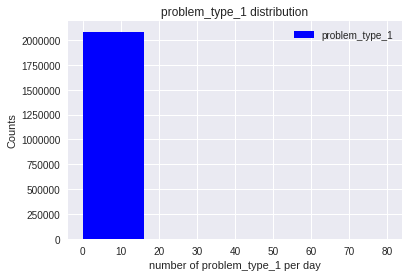

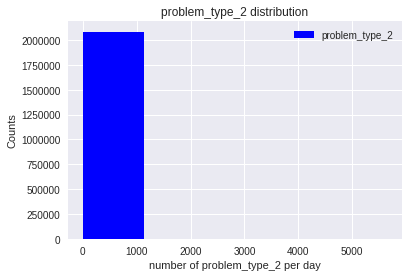

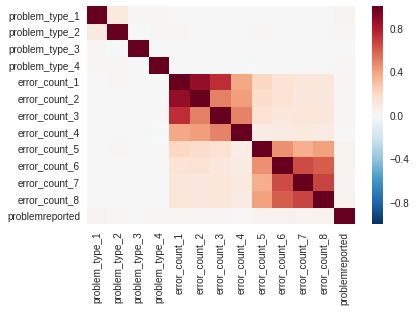

In [10]:
# Registra o dataframe como uma tabela temporária no contexto SQL
df.createOrReplaceTempView("df1")

sqlStatement = """
    SELECT problem_type_1, problem_type_2, problem_type_3, problem_type_4,
    error_count_1, error_count_2, error_count_3, error_count_4, 
    error_count_5, error_count_6, error_count_7, error_count_8, problemreported
    FROM df1
"""
plotdata = spark.sql(sqlStatement).toPandas();


%matplotlib inline

# Mostra a distribuição do histograma de algumas características
ax1 = plotdata[['problem_type_1']].plot(kind='hist', bins=5, facecolor='blue')
ax1.set_title('problem_type_1 distribution')
ax1.set_xlabel('number of problem_type_1 per day'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()

ax1 = plotdata[['problem_type_2']].plot(kind='hist', bins=5, facecolor='blue')
ax1.set_title('problem_type_2 distribution')
ax1.set_xlabel('number of problem_type_2 per day'); ax1.set_ylabel('Counts');
plt.figure(figsize=(4,4)); plt.suptitle(''); plt.show()


# Mostra o mapa de calor da matriz de correlação para explorar alguns possíveis padrões interessantes
corr = plotdata.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

## Feature Engineering

No restante deste notebook, demonstraremos como gerar novos recursos para esse tipo de caso de uso. 

Na célula a seguir, criamos alguns recursos de tempo, calculados a partir do número total de warning_type1 (type2) ocorridos para uma máquina em um determinado dia. Também identificamos alguns problemas de qualidade de dados que algumas contagens de eventos tiveram valores negativos.

In [11]:
# Extrai alguns recursos de tempo da coluna "data"
df = df.withColumn('month', month(df['date']))
df = df.withColumn('weekofyear', weekofyear(df['date']))
df = df.withColumn('dayofmonth', dayofmonth(df['date']))


# Recursos brutos relacionados ao warning
warning_type1_features = list(s for s in df.columns if "warning_1_" in s) 
                            
warning_type2_features = list(s for s in df.columns if "warning_2_" in s)

warning_all = warning_type1_features + warning_type2_features

# Contagem total de todos os warnings do tipo1 todos os dias em cada dispositivo
df = df.withColumn('warn_type1_total', sum(df[col_n] for col_n in warning_type1_features))

# Contagem total de todos os warnings do tipo2 todos os dias em cada dispositivo
df = df.withColumn('warn_type2_total', sum(df[col_n] for col_n in warning_type2_features))

print(df['warn_type1_total',].head(3))
print(df['warn_type2_total',].head(3))


[Row(warn_type1_total=-430), Row(warn_type1_total=-430), Row(warn_type1_total=-419)]
[Row(warn_type2_total=-1040), Row(warn_type2_total=-1040), Row(warn_type2_total=-1040)]


In [12]:
# Percebemos que as contagens de aviso têm valores negativos
# Substituímos todos os valores negativos por 0

def negative_replace(num):
    if num < 0: return 0
    else: return num
    
negative_replace_Udf = udf(negative_replace, IntegerType())

m = warning_type1_features + warning_type2_features
for col_n in m:
    df = df.withColumn(col_n, negative_replace_Udf(df[col_n]))

# Então nós temos que recalcular o total de avisos novamente
df = df.withColumn('warn_type1_total', sum(df[col_n] for col_n in warning_type1_features))
df = df.withColumn('warn_type2_total', sum(df[col_n] for col_n in warning_type2_features))

print(df['warn_type1_total',].head(3))
print(df['warn_type2_total',].head(3))

[Row(warn_type1_total=0), Row(warn_type1_total=0), Row(warn_type1_total=1)]
[Row(warn_type2_total=0), Row(warn_type2_total=0), Row(warn_type2_total=0)]


#### As variáveis "categorical_1 a 4" são do tipo inteiro, mas na verdade são recursos categóricos. Na célula a seguir, categorizamos essas variáveis e criamos quatro novas colunas.

In [13]:
# Nota: também podemos usar o SparkSQL para essa tarefa de categorização

def Cat1(num):
    if num <= 10: return '0-10'
    elif 10 < num and num <= 20: return '11-20'
    elif 20 < num and num <= 30: return '21-30'
    elif 30 < num and num <= 40: return '31-40'
    else: return 'morethan40'
cat1Udf = udf(Cat1, StringType())
df = df.withColumn("cat1", cat1Udf('categorical_1'))


def Cat2(num):
    if num <= 2000: return '0-2000'
    elif 2000 < num and num <= 3000: return '2000-3000'
    elif 3000 < num and num <= 4000: return '3000-4000'
    elif 4000 < num and num <= 5000: return '4000-5000'
    elif 5000 < num and num <= 6000: return '5000-6000'
    else: return 'morethan6000'
cat2Udf = udf(Cat2, StringType())
df = df.withColumn("cat2", cat2Udf('categorical_2'))


def Cat3(num):
    if num <= 200: return '0-200'
    elif 200 < num and num <= 400: return '200-400'
    elif 400 < num and num <= 600: return '400-600'
    elif 600 < num and num <= 800: return '600-800'
    else: return 'morethan800'
cat3Udf = udf(Cat3, StringType())
df = df.withColumn("cat3", cat3Udf('categorical_3'))


def Cat4(num):
    if num <= 5000: return '0-5000'
    elif 5000 < num and num <= 10000: return '5000-10000'
    elif 10000 < num and num <= 15000: return '10000-15000'
    elif 15000 < num and num <= 20000: return '15000-20000'
    else: return 'morethan20000'
cat4Udf = udf(Cat4, StringType())
df = df.withColumn("cat4", cat4Udf('categorical_4'))


print(df.select('cat1').distinct().rdd.map(lambda r: r[0]).collect())
print(df.select('cat2').distinct().rdd.map(lambda r: r[0]).collect())
print(df.select('cat3').distinct().rdd.map(lambda r: r[0]).collect())
print(df.select('cat4').distinct().rdd.map(lambda r: r[0]).collect())


[u'11-20', u'21-30', u'0-10', u'31-40']
[u'2000-3000', u'morethan6000', u'5000-6000', u'3000-4000', u'0-2000', u'4000-5000']
[u'600-800', u'200-400', u'400-600', u'0-200']
[u'5000-10000', u'morethan20000', u'0-5000', u'15000-20000', u'10000-15000']


#### Para as variáveis "fault_code_type_1 a 4", se for "Desconhecido", significa que há um código de falha "0" relatado naquele dia para aquela máquina, caso contrário, a contagem do tipo de código de falha 1 (2, 3 ou 4) é 1.

In [14]:
df = df.withColumn("fault_code_type_1_count",F.when(df.fault_code_type_1!= "Unknown", 1).otherwise(0))\
       .withColumn("fault_code_type_2_count",F.when(df.fault_code_type_2!= "Unknown", 1).otherwise(0))\
       .withColumn("fault_code_type_3_count",F.when(df.fault_code_type_3!= "Unknown", 1).otherwise(0))\
       .withColumn("fault_code_type_4_count",F.when(df.fault_code_type_4!= "Unknown", 1).otherwise(0))

df.groupby('fault_code_type_1_count').count().show()
df.groupby('fault_code_type_2_count').count().show()
df.groupby('fault_code_type_3_count').count().show()
df.groupby('fault_code_type_4_count').count().show()


+-----------------------+-------+
|fault_code_type_1_count|  count|
+-----------------------+-------+
|                      1|  50636|
|                      0|2034466|
+-----------------------+-------+

+-----------------------+-------+
|fault_code_type_2_count|  count|
+-----------------------+-------+
|                      1|  65676|
|                      0|2019426|
+-----------------------+-------+

+-----------------------+-------+
|fault_code_type_3_count|  count|
+-----------------------+-------+
|                      1|  86409|
|                      0|1998693|
+-----------------------+-------+

+-----------------------+-------+
|fault_code_type_4_count|  count|
+-----------------------+-------+
|                      1|  39593|
|                      0|2045509|
+-----------------------+-------+



#### Recursos relacionados ao desempenho de engenharia de recursos

Primeiro, selecionamos 8 recursos de desempenho bruto para serem normalizados e, em seguida, selecionamos 2 normalizadores.

A ideia por trás dessa normalização é que o dispositivo com mais problema / erro / falha relatado pode simplesmente ser usado com mais frequência. Portanto, precisamos normalizar as contagens de problemas pelas contagens de uso correspondentes.

In [15]:
# Primeiro, selecione os 8 recursos de desempenho brutos a serem normalizados
performance_normal_raw = ['problem_type_1','problem_type_2','problem_type_3','problem_type_4',
                          'fault_code_type_1_count','fault_code_type_2_count',
                          'fault_code_type_3_count', 'fault_code_type_4_count']

# Então, selecionamos 2 normalizadores
performance_normalizer = ['usage_count_1','usage_count_2']

# Normalizamos performance_normal_raw por "usage_count_1"
df = df.withColumn("problem_type_1_per_usage1", F.when(df.usage_count_1==0,0).otherwise(df.problem_type_1/df.usage_count_1))\
       .withColumn("problem_type_2_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.problem_type_2/df.usage_count_1))\
       .withColumn("problem_type_3_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.problem_type_3/df.usage_count_1))\
       .withColumn("problem_type_4_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.problem_type_4/df.usage_count_1))\
       .withColumn("fault_code_type_1_count_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.fault_code_type_1_count/df.usage_count_1))\
       .withColumn("fault_code_type_2_count_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.fault_code_type_2_count/df.usage_count_1))\
       .withColumn("fault_code_type_3_count_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.fault_code_type_3_count/df.usage_count_1))\
       .withColumn("fault_code_type_4_count_per_usage1",F.when(df.usage_count_1==0,0).otherwise(df.fault_code_type_4_count/df.usage_count_1))

# Normalizamos performance_normal_raw por "usage_count_2"
df = df.withColumn("problem_type_1_per_usage2", F.when(df.usage_count_2==0,0).otherwise(df.problem_type_1/df.usage_count_2))\
       .withColumn("problem_type_2_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.problem_type_2/df.usage_count_2))\
       .withColumn("problem_type_3_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.problem_type_3/df.usage_count_2))\
       .withColumn("problem_type_4_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.problem_type_4/df.usage_count_2))\
       .withColumn("fault_code_type_1_count_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.fault_code_type_1_count/df.usage_count_2))\
       .withColumn("fault_code_type_2_count_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.fault_code_type_2_count/df.usage_count_2))\
       .withColumn("fault_code_type_3_count_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.fault_code_type_3_count/df.usage_count_2))\
       .withColumn("fault_code_type_4_count_per_usage2",F.when(df.usage_count_2==0,0).otherwise(df.fault_code_type_4_count/df.usage_count_2))


#### Semelhante ao que fizemos para "categorical_1 a 4", na célula a seguir listamos os recursos relacionados ao desempenho e criamos novos recursos categóricos.

In [16]:
# Defina a lista de recursos relacionados ao desempenho que gostaríamos de executar a categorização
c_names = ['problem_type_1', 'problem_type_3', 'problem_type_4',
           'problem_type_1_per_usage1','problem_type_2_per_usage1','problem_type_3_per_usage1','problem_type_4_per_usage1',
           'problem_type_1_per_usage2','problem_type_2_per_usage2','problem_type_3_per_usage2','problem_type_4_per_usage2',
           'fault_code_type_1_count', 'fault_code_type_2_count', 'fault_code_type_3_count', 'fault_code_type_4_count',                          
           'fault_code_type_1_count_per_usage1','fault_code_type_2_count_per_usage1',
           'fault_code_type_3_count_per_usage1', 'fault_code_type_4_count_per_usage1',
           'fault_code_type_1_count_per_usage2','fault_code_type_2_count_per_usage2',
           'fault_code_type_3_count_per_usage2', 'fault_code_type_4_count_per_usage2']

# Tamanho do compartimento ('0', '1', '> 1') para a maioria dos recursos de desempenho porque 
# a maioria dos valores se enquadra no intervalo de 0 a pouco mais de 1.
def performanceCat(num):
    if num == 0: return '0'
    elif num ==1: return '1'
    else: return '>1'
    
performanceCatUdf = udf(performanceCat, StringType())
for col_n in c_names:
    df = df.withColumn(col_n+'_category',performanceCatUdf(df[col_n]))

# Use bin diferente para "problem_type_2" porque vimos um spread maior dos valores
def problem_type_2_Cat(num):
    if num == 0: return '0'
    elif 0 < num and num <= 5: return '1-5'
    elif 5 < num and num <= 10: return '6-10'
    else: return '>10'

problem_type_2_CatUdf = udf(problem_type_2_Cat, StringType())
df = df.withColumn('problem_type_2_category',problem_type_2_CatUdf(df['problem_type_2']))


print(df.select('problem_type_1_category').distinct().rdd.map(lambda r: r[0]).collect())
print(df.select('problem_type_2_category').distinct().rdd.map(lambda r: r[0]).collect())

[u'0', u'>1', u'1']
[u'>10', u'0', u'6-10', u'1-5']


#### One-Hot Encode Para Alguns Atributos Categóricos

In [17]:
%%time

# Definir a lista de recursos categóricos

catVarNames = ['problem_type_1_category', 'problem_type_2_category',
               'problem_type_3_category', 'problem_type_4_category',
               'problem_type_1_per_usage1_category', 'problem_type_2_per_usage1_category',
               'problem_type_3_per_usage1_category', 'problem_type_4_per_usage1_category',
               'problem_type_1_per_usage2_category', 'problem_type_2_per_usage2_category',
               'problem_type_3_per_usage2_category', 'problem_type_4_per_usage2_category',
               'fault_code_type_1_count_category', 'fault_code_type_2_count_category',
               'fault_code_type_3_count_category', 'fault_code_type_4_count_category',
               'fault_code_type_1_count_per_usage1_category', 'fault_code_type_2_count_per_usage1_category',
               'fault_code_type_3_count_per_usage1_category', 'fault_code_type_4_count_per_usage1_category',
               'fault_code_type_1_count_per_usage2_category', 'fault_code_type_2_count_per_usage2_category',
               'fault_code_type_3_count_per_usage2_category', 'fault_code_type_4_count_per_usage2_category',
               'cat1','cat2','cat3','cat4']
    
    
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]

df_cat = Pipeline(stages=sIndexers).fit(df).transform(df)

# Remover colunas com apenas 1 nível (computar variações de colunas)
catColVariance = df_cat.select(
    *(F.variance(df_cat[c]).alias(c + '_sd') for c in [cv + '_indexed' for cv in catVarNames]))
catColVariance = catColVariance.rdd.flatMap(lambda x: x).collect()
catVarNames = [catVarNames[k] for k in [i for i, v in enumerate(catColVariance) if v != 0]]

# Encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]
ohPipelineModel = Pipeline(stages=ohEncoders).fit(df_cat)
df_cat = ohPipelineModel.transform(df_cat)

drop_list = [col_n for col_n in df_cat.columns if 'indexed' in col_n]
df = df_cat.select([column for column in df_cat.columns if column not in drop_list])

print(df['problem_type_1_category_encoded',].head(3))

[Row(problem_type_1_category_encoded=SparseVector(2, {0: 1.0})), Row(problem_type_1_category_encoded=SparseVector(2, {0: 1.0})), Row(problem_type_1_category_encoded=SparseVector(2, {0: 1.0}))]
CPU times: user 747 ms, sys: 199 ms, total: 946 ms
Wall time: 13min 22s


#### Usando PCA Para Reduzir o Número de Recursos

Na parte 2, executaremos uma série de cálculos contínuos para vários recursos, janelas de tempo e estatísticas agregadas. Este processo é muito dispendioso e, portanto, precisamos primeiro reduzir a lista de recursos.
No conjunto de dados, há muitos recursos relacionados a avisos e a maioria deles tem valor 0 muito escasso. Podemos agrupar ou encontrar correlações entre esses recursos de aviso, reduzir o espaço de recursos para o trabalho de recebimento de dados.

In [18]:
## Verifique o número de recursos relacionados ao aviso
len([col_n for col_n in df.columns if 'warning' in col_n])

147

In [19]:
%%time

#----------------------------- Agrupamento de recursos do PCA em recursos relacionados ao aviso --------------------------#

df = df.withColumn("key", concat(df.deviceid,lit("_"),df.date))

# Passo 1
# Use RFormula para criar o vetor de recurso
formula = RFormula(formula = "~" + "+".join(warning_all))
output = formula.fit(df).transform(df).select("key","features") 


# Passo 2
# Antes PCA, precisamos padronizar os recursos, é muito importante ...
# Observe que o StandardScaler não funciona para vetor esparso, a menos que comMean = false
# OU podemos converter vetor esparso em vetor denso usando primeiramente o Array
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

# Calcule estatísticas de resumo, ajustando o StandardScaler
scalerModel = scaler.fit(output)

# Normalize cada recurso para ter desvio padrão da unidade.
scaledData = scalerModel.transform(output)


# Passo 3
pca = PCA(k=20, inputCol="scaledFeatures", outputCol="pcaFeatures")
model = pca.fit(scaledData)
result = model.transform(scaledData).select("key","pcaFeatures")

# Para verificar quanta variação foi explicada por cada componente
print(model.explainedVariance)  


# Passo 4
# converter resultado pca, uma coluna vetorial, em várias colunas
# A razão pela qual fizemos isso foi porque, mais tarde, precisamos usar essas colunas para gerar mais recursos (rolling compute)
def extract(row):
    return (row.key, ) + tuple(float(x) for x in row.pcaFeatures.values)

pca_outcome = result.rdd.map(extract).toDF(["key"])

# Renomear colunas de pca_outcome
oldColumns = pca_outcome.schema.names

newColumns = ["key", 
              "pca_1_warn","pca_2_warn","pca_3_warn","pca_4_warn","pca_5_warn",
              "pca_6_warn","pca_7_warn","pca_8_warn","pca_9_warn","pca_10_warn",
              "pca_11_warn","pca_12_warn","pca_13_warn","pca_14_warn","pca_15_warn",
              "pca_16_warn","pca_17_warn","pca_18_warn","pca_19_warn","pca_20_warn",
             ]

pca_result = reduce(lambda pca_outcome, idx: pca_outcome.withColumnRenamed(oldColumns[idx], newColumns[idx]), \
                                        xrange(len(oldColumns)), pca_outcome)

df = df.join(pca_result, 'key', 'inner')

print(df['pca_1_warn',].head(3))

warning_drop_list = [col_n for col_n in df.columns if 'warning_' in col_n]
df = df.select([column for column in df.columns if column not in warning_drop_list])


[0.0483107423499,0.0278314776592,0.0254509402103,0.0236091224214,0.0200247085239,0.0188475892993,0.0183962875162,0.0177510201652,0.0167993077022,0.0163456905185,0.016006950633,0.0155092512672,0.0144804538583,0.0140982528803,0.0139322569416,0.0137500740086,0.0136491126177,0.0129200916821,0.0122476113985,0.0115038758841]
[Row(pca_1_warn=0.0), Row(pca_1_warn=0.0), Row(pca_1_warn=0.0)]
CPU times: user 191 ms, sys: 39.2 ms, total: 230 ms
Wall time: 2min 43s


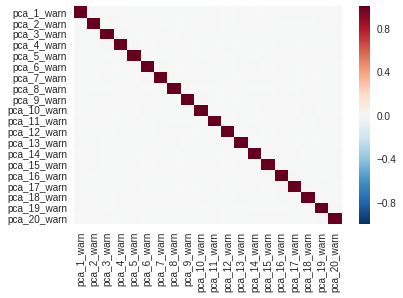

In [20]:
# Eu gostaria de visualizar a relação entre os 20 componentes pca

# Registra o dataframe como uma tabela temporária no contexto SQL
df.createOrReplaceTempView("df2")

sqlStatement2 = """
    SELECT pca_1_warn, pca_2_warn, pca_3_warn, pca_4_warn, pca_5_warn, 
    pca_6_warn, pca_7_warn, pca_8_warn, pca_9_warn, pca_10_warn,
    pca_11_warn, pca_12_warn, pca_13_warn, pca_14_warn, pca_15_warn, 
    pca_16_warn, pca_17_warn, pca_18_warn, pca_19_warn, pca_20_warn
    FROM df2
"""
plotdata2 = spark.sql(sqlStatement2).toPandas();


%matplotlib inline

# Mostrar o mapa de calor da matriz de correlação para explorar alguns possíveis padrões interessantes
corr = plotdata2.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

# A partir do plot, podemos ver os 20 componentes pca não se sobrepõem muito o que é esperado


## Salvando o Resultado Intermediário em Formato Parquet

Devido ao tipo de computação do Spark, geralmente é mais eficiente dividir a carga de trabalho em partes e materializar os resultados intermediários. Por exemplo, dividimos o projeto em três notebooks, o resultado do Notebook # 1 será usado como dados de entrada para o Notebook # 2.

In [21]:
%%time

df.write.mode('overwrite').parquet('notebook1_resultado.parquet')

CPU times: user 87.6 ms, sys: 58.6 ms, total: 146 ms
Wall time: 2min 3s


# Fim - Parte 1